<a href="https://colab.research.google.com/github/sergiorkd/CmapssFailurePrediction/blob/main/TCC_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Database Description

The analyzed dataset is provided by NASA's Ames Prognostics Center of Excellence (PCoE), available on their website. For this study, dataset number 6, "Turbofan Engine Degradation Simulation," was used. Its translated description is as follows:

"The simulation of turbine degradation was performed using the C-MAPSS tool. Four simulations were created, considering different combinations of operational conditions and fault modes. Multiple sensor readings were used to characterize the failure progression. The dataset was provided by NASA's Ames Prognostics Center of Excellence (PCoE)."

This dataset was used in the 2008 PHM (Prognostic and Health Management) competition. A text file was provided containing the following translated information about the data format: Experimental Scenario

The datasets consist of multivariate time series. Each dataset is divided into training and test subsets. Each time series corresponds to a different engine, meaning the data can be considered as coming from a fleet of engines of the same type. Each engine starts with varying initial wear and unknown manufacturing variation, which are considered normal and not failure conditions.

There are three operational settings that have a substantial effect on engine performance. These settings are also included in the dataset. Sensor noise is present in the data.

Each engine operates normally at the beginning of its time series and develops a fault at some point during the sequence. In the training set, the fault magnitude increases until the system fails. In the test set, the time series ends some time before system failure. A vector of true Remaining Useful Life (RUL) values is also provided for the test set.

The data is provided as a zipped text file containing 26 numeric columns separated by spaces. Each line represents a data capture from a single operational cycle. Each column corresponds to a different variable, as described below:

Unit number

Time, in cycles

Operational setting 1

Operational setting 2

Operational setting 3

Sensor measurement 1

Sensor measurement 2

...

Sensor measurement 21


In [4]:
# Core libraries
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Preprocessing & Model Selection
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# Sklearn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

# Sklearn - Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# Sklearn - Dimensionality Reduction
from sklearn.decomposition import PCA

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)


In [5]:
# Define column names for the datasets
nomes_indices = ['id_unidade', 'tempo_ciclos']
nomes_configuracoes = ['config_1', 'config_2', 'config_3']
nomes_sensores = ['s_{}'.format(i+1) for i in range(0, 21)]
nomes_colunas = nomes_indices + nomes_configuracoes + nomes_sensores

# Load datasets with custom column names
df_treino = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=nomes_colunas)
df_valid = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=nomes_colunas)
df_rul = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['ciclos_restantes'])

## Exploratory analysis

In this study only the FD001 data base will be used, this data simulates the high pressure compressor degradation.

In [6]:
# Copy the original datasets to isolate the FD001 subset
fd001_treino = df_treino.copy()
fd001_valid = df_valid.copy()
fd001_rul = df_rul.copy()

# Display basic information about the training set
print('Training set has', fd001_treino.shape[0], 'observations with', fd001_treino.shape[1] - 1, 'variables')

# Count the number of unique units (engines) in the validation set
turbinas_distintas = fd001_valid['id_unidade'].nunique()

# Display basic information about the validation set
print('Test set has', fd001_valid.shape[0], 'observations with', fd001_valid.shape[1] - 1, 'variables and',
      turbinas_distintas, 'distinct engines')

# Display basic information about the RUL (Remaining Useful Life) set
print('RUL set has', fd001_rul.shape[0], 'observations with', fd001_rul.shape[1] - 1, 'variables')

Training set has 20631 observations with 25 variables
Test set has 13096 observations with 25 variables and 100 distinct engines
RUL set has 100 observations with 0 variables


In [7]:
# Check for missing values in any of the datasets
if (fd001_treino.isnull().values.any() or
    fd001_valid.isnull().values.any() or
    fd001_rul.isnull().values.any()):
    print('Missing values found')
else:
    print('No missing values found')

No missing values found


In [8]:
# Giving real names to the variables
sensor_dict={}
dict_list=[
"Configuration 1",
"Configuration 2",
"Configuration 3",
"(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    sensor_dict['s_'+str(i)]=x
    i+=1

In [9]:
def format_sobrescrito(x):
    """
    Formats a number in scientific notation using Unicode superscript for the exponent.
    If the input is not a number, it is returned unchanged.
    """
    if isinstance(x, (float, int)):
        # Format number in scientific notation (e.g., 1.23e+04)
        formatted = "{:.2e}".format(x)
        base, exp = formatted.split('e')
        exp = int(exp)

        # Map digits and minus sign to Unicode superscript characters
        sobrescrito = str.maketrans('0123456789-', '⁰¹²³⁴⁵⁶⁷⁸⁹⁻')

        return f"{base} × 10{str(exp).translate(sobrescrito)}"

    return x

In [10]:
# Drop identifier columns to keep only sensor and configuration data
descritivo_treino = fd001_treino.drop(columns=nomes_indices)
descritivo_valid = fd001_valid.drop(columns=nomes_indices)

# Create a descriptive statistics DataFrame
df_descritivo = pd.DataFrame({
    'Variable': descritivo_treino.columns,
    'Variable Name': dict_list,
    'Train Mean': descritivo_treino.mean(),
    'Train Std Dev': descritivo_treino.std(),
    'Validation Mean': descritivo_valid.mean(),
    'Validation Std Dev': descritivo_valid.std()
})

# Reset index to clean up the DataFrame layout
df_descritivo.reset_index(drop=True, inplace=True)

# Apply superscript formatting to numeric values
numeric_columns = ['Train Mean', 'Train Std Dev', 'Validation Mean', 'Validation Std Dev']
df_descritivo_format = df_descritivo.copy()
df_descritivo_format[numeric_columns] = df_descritivo[numeric_columns].applymap(format_sobrescrito)

# Display the formatted DataFrame
df_descritivo_format

,Variable,Variable Name,Train Mean,Train Std Dev,Validation Mean,Validation Std Dev
0,config_1,Configuration 1,-8.87 × 10⁻⁶,2.19 × 10⁻³,-1.12 × 10⁻⁵,2.20 × 10⁻³
1,config_2,Configuration 2,2.35 × 10⁻⁶,2.93 × 10⁻⁴,4.24 × 10⁻⁶,2.94 × 10⁻⁴
2,config_3,Configuration 3,1.00 × 10²,0.00 × 10⁰,1.00 × 10²,0.00 × 10⁰
3,s_1,(Fan inlet temperature) (◦R),5.19 × 10²,6.54 × 10⁻¹¹,5.19 × 10²,6.01 × 10⁻¹¹
4,s_2,(LPC outlet temperature) (◦R),6.43 × 10²,5.00 × 10⁻¹,6.42 × 10²,4.01 × 10⁻¹
5,s_3,(HPC outlet temperature) (◦R),1.59 × 10³,6.13 × 10⁰,1.59 × 10³,5.00 × 10⁰
6,s_4,(LPT outlet temperature) (◦R),1.41 × 10³,9.00 × 10⁰,1.40 × 10³,6.69 × 10⁰
7,s_5,(Fan inlet Pressure) (psia),1.46 × 10¹,3.39 × 10⁻¹²,1.46 × 10¹,2.67 × 10⁻¹²
8,s_6,(bypass-duct pressure) (psia),2.16 × 10¹,1.39 × 10⁻³,2.16 × 10¹,1.70 × 10⁻³
9,s_7,(HPC outlet pressure) (psia),5.53 × 10²,8.85 × 10⁻¹,5.54 × 10²,6.81 × 10⁻¹


In [11]:
# Define a tolerance threshold to consider values "close to zero"
limite = 1e-3

# Filter rows where both standard deviations
#(train and validation) are close to zero
df_filtrado = df_descritivo[
    (df_descritivo['Train Std Dev'].abs() < limite) &
    (df_descritivo['Validation Std Dev'].abs() < limite)
]

# Reset index for clean display
df_filtrado.reset_index(drop=True, inplace=True)

# Apply scientific notation formatting to numeric values
variaveis = ['Train Mean', 'Train Std Dev',
             'Validation Mean', 'Validation Std Dev']
df_filtrado_format = df_filtrado.copy()
df_filtrado_format[variaveis] = df_filtrado_format[variaveis].applymap(format_sobrescrito)

# Display formatted filtered DataFrame
df_filtrado_format

,Variable,Variable Name,Train Mean,Train Std Dev,Validation Mean,Validation Std Dev
0,config_2,Configuration 2,2.35 × 10⁻⁶,2.93 × 10⁻⁴,4.24 × 10⁻⁶,2.94 × 10⁻⁴
1,config_3,Configuration 3,1.00 × 10²,0.00 × 10⁰,1.00 × 10²,0.00 × 10⁰
2,s_1,(Fan inlet temperature) (◦R),5.19 × 10²,6.54 × 10⁻¹¹,5.19 × 10²,6.01 × 10⁻¹¹
3,s_5,(Fan inlet Pressure) (psia),1.46 × 10¹,3.39 × 10⁻¹²,1.46 × 10¹,2.67 × 10⁻¹²
4,s_10,(Engine pressure ratio(P50/P2),1.30 × 10⁰,4.66 × 10⁻¹³,1.30 × 10⁰,3.16 × 10⁻¹³
5,s_16,(Burner fuel-air ratio),3.00 × 10⁻²,1.56 × 10⁻¹⁴,3.00 × 10⁻²,8.82 × 10⁻¹⁵
6,s_18,(Required fan speed),2.39 × 10³,0.00 × 10⁰,2.39 × 10³,0.00 × 10⁰
7,s_19,(Required fan conversion speed),1.00 × 10²,0.00 × 10⁰,1.00 × 10²,0.00 × 10⁰


In [12]:
fd001_treino['config_2'].max()

0.0006

In [13]:
fd001_treino['config_2'].min()

-0.0006

### Observations

- There are no missing values, as expected from a simulated dataset.
- Both the training and test sets contain 100 time series, which can be confirmed by checking the maximum unit ID value.
- The statistical distribution of the cycle count supports the expected behavior: in the test set, engines were removed upon failure, while in the training set, removal occurred earlier. This is reflected in the higher mean and median cycle values in the training set (108.81 and 104.0) compared to the test set (76.84 and 69.0).

## Creating graphs to analise the variables

### Training base

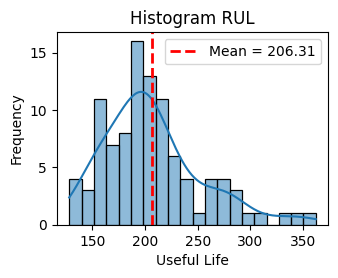

In [14]:
# Compute the number of cycles until failure for each unit
ciclos_ate_falha = fd001_treino[nomes_indices].groupby('id_unidade').max()

# Calculate the mean number of cycles until failure
media_ciclos = ciclos_ate_falha['tempo_ciclos'].mean()

# Create the figure with appropriate dimensions (3.5 inches wide = 88.9 mm)
fig, ax = plt.subplots(figsize=(3.5, 2.5))  # Adjust height as needed

# Plot histogram with KDE (Kernel Density Estimate)
sns.histplot(ciclos_ate_falha['tempo_ciclos'], kde=True, bins=20, ax=ax)

# Add a vertical line indicating the mean
ax.axvline(media_ciclos, color='red', linestyle='--',
           linewidth=2, label=f'Mean = {media_ciclos:.2f}')

# Customize plot labels and title
ax.set_title('Histogram RUL')
ax.set_xlabel('Useful Life')
ax.set_ylabel('Frequency')

# Show legend
ax.legend()

# Display the plot
plt.show()

É possível perceber que o tempo de vida das turbinas se concentra entre 190 e 210 ciclos.

In [15]:
# Creating the remaining useful life information
def calcularCiclos(df):
    tabela_agrupada = df.groupby(by='id_unidade')
    ciclos_maximos = tabela_agrupada['tempo_ciclos'].max()
    mesclada = df.merge(ciclos_maximos.to_frame(name='maior_ciclo'),
                        left_on='id_unidade', right_index=True)
    mesclada['RUL'] = mesclada['maior_ciclo'] - mesclada['tempo_ciclos']
    mesclada = mesclada.drop('maior_ciclo', axis=1)
    return mesclada

fd001_treino = calcularCiclos(fd001_treino)

In [16]:
fd001_treino

,id_unidade,tempo_ciclos,config_1,config_2,config_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


### Avaliando a correlação entre as variáveis

In [17]:
fd001_treino.columns

Index(['id_unidade', 'tempo_ciclos', 'config_1', 'config_2', 'config_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21', 'RUL'],
      dtype='object')

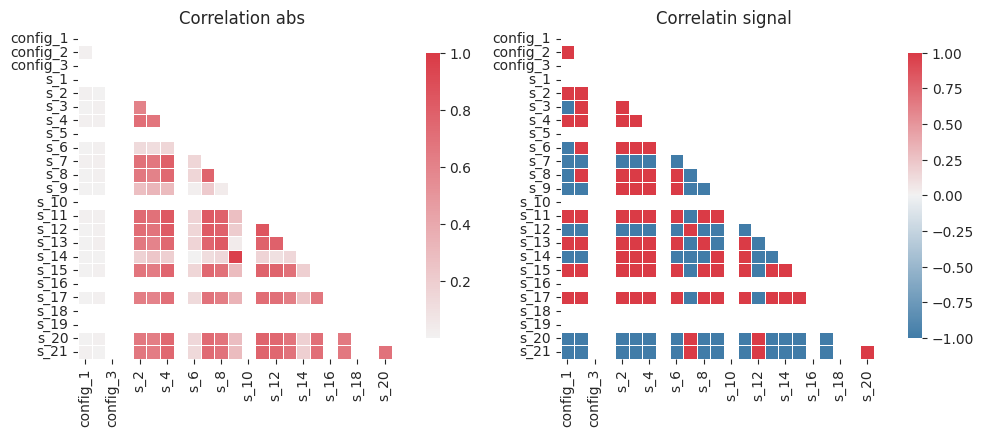

In [18]:
sns.set_style("ticks")

# List of wanted variables
variaveis_interesse = nomes_configuracoes + nomes_sensores
corr = fd001_treino[variaveis_interesse].corr()

# Creates a mask to hide the upper part of the triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Creates a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Graph 1: Correlation absolute value
cmap_abs = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr.abs(), mask=mask, cmap=cmap_abs, vmax=1,
            center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": .5}, ax=axes[0])
axes[0].set_title('Correlation abs')

# Graph 2: this shows the correlation signal
cmap_sign = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(np.sign(corr), mask=mask, cmap=cmap_sign, vmax=1,
            center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": .5}, ax=axes[1])
axes[1].set_title('Correlatin signal')

plt.tight_layout()
plt.show()

In [19]:
corr_matrix = fd001_treino[variaveis_interesse].corr()

# Convert the correlation matrix into a DataFrame
corr_df = corr_matrix.unstack().reset_index()
corr_df.columns = ['Variável 1', 'Variável 2', 'Correlação']

# Remove duplicate correlations and self-correlations (a variable with itself)
corr_df = corr_df[corr_df['Variável 1'] != corr_df['Variável 2']]

# Remove duplicates where 'Variable 1' and 'Variable 2' are swapped
corr_df['Pairs'] = list(zip(corr_df['Variável 1'], corr_df['Variável 2']))
corr_df['Pairs'] = corr_df['Pairs'].apply(lambda x: tuple(sorted(x)))
corr_df = corr_df.drop_duplicates(subset='Pairs').drop(columns='Pairs')

# Sort by absolute correlation value, from highest to lowest
corr_df['Abs_Correlação'] = corr_df['Correlação'].abs()
corr_df = corr_df.sort_values(by='Abs_Correlação', ascending=False)
corr_df = corr_df.drop(columns='Abs_Correlação')

In [20]:
# Sort by absolute correlation value, from highest to lowest
corr_df.dropna(inplace=True)
corr_df['Abs_Correlação'] = corr_df['Correlação'].abs()
corr_df = corr_df.sort_values(by='Abs_Correlação', ascending=False)

# Filter correlations with absolute value greater than 0.8
corr_df_filtrado = corr_df[corr_df['Abs_Correlação'] > 0.8].drop(columns='Abs_Correlação')
corr_df_filtrado

,Variável 1,Variável 2,Correlação
280,s_9,s_14,0.963157
326,s_11,s_12,-0.846884
157,s_4,s_11,0.830136
255,s_8,s_13,0.826084
229,s_7,s_11,-0.822805
158,s_4,s_12,-0.815591
230,s_7,s_12,0.812713


É possível perceber que existem variáveis, como os sensores 9 e 14, que possuem elevada correlação.

In [21]:
def plot_sensores(df, unidades_especificas, janela_movel=10,
                  title_fontsize=12, label_fontsize=8, legend_fontsize=8,
                  axis_fontsize=8, line_width=0.8):

    # Identifying all sensors
    sensores = [f's_{i}' for i in range(1, 22)] + nomes_configuracoes

    for sensor in sensores:
        # Convert width to inches
        width_inches = 88.9 / 25.4
        height_inches = width_inches * 0.75  # Maintain aspect ratio

        # Creating a new figure with appropriate width
        plt.figure(figsize=(width_inches, height_inches))

        # Plotting data for each sensor and unit
        for unit_id in unidades_especificas:
            try:
                subset = df[df['id_unidade'] == unit_id]
                subset_sorted = subset.sort_values('RUL')
                subset_sorted[f'{sensor}_rolling'] = subset_sorted[sensor].rolling(window=janela_movel).mean()

                # Define a thinner line width
                plt.plot(subset_sorted['RUL'], subset_sorted[f'{sensor}_rolling'],
                         label=f'Unit {unit_id}', linewidth=line_width)
            except KeyError:
                continue

        # Setting axis limits and ticks
        plt.xlim(250, 0)
        plt.xticks(np.arange(0, 300, 25), fontsize=axis_fontsize)
        plt.yticks(fontsize=axis_fontsize)

        # Adding title and labels with adjusted font sizes
        plt.title(sensor, fontsize=title_fontsize)
        plt.xlabel('Remaining Useful Life', fontsize=label_fontsize)

        # Adding legend
        plt.legend(fontsize=legend_fontsize)

        # Closing the figure to avoid plot overlap
        plt.close()

unidades = [1, 12, 28, 68]
plot_sensores(fd001_treino, unidades, line_width=0.8)

In [22]:
def plot_selected_sensors(df, unidades_especificas, janela_movel=10,
                          title_fontsize=12, label_fontsize=8,
                          legend_fontsize=8, axis_fontsize=8, line_width=0.8):

    # Selecting sensors
    sensores = ['s_12', 's_8', 's_9']

    for sensor in sensores:
        # Converting measurements to inches
        width_inches = 88.9 / 25.4
        height_inches = width_inches * 0.75  # Maintaining aspect ratio

        # Creating figure
        plt.figure(figsize=(width_inches, height_inches))

        # Plotting data for each unit
        for unit_id in unidades_especificas:
            try:
                subset = df[df['id_unidade'] == unit_id]
                subset_sorted = subset.sort_values('RUL')
                subset_sorted[f'{sensor}_rolling'] = subset_sorted[sensor].rolling(window=janela_movel).mean()

                # Plotting the sensor curve with a thinner line
                plt.plot(subset_sorted['RUL'], subset_sorted[f'{sensor}_rolling'],
                         label=f'Unit {unit_id}', linewidth=line_width)
            except KeyError:
                continue

        # Adding a vertical line at RUL = 50
        plt.axvline(x=50, color='red', linestyle='dashed',
                    linewidth=1.0, label="RUL = 50")

        # Setting axis limits and ticks
        plt.xlim(250, 0)
        plt.xticks(np.arange(0, 300, 25), fontsize=axis_fontsize)
        plt.yticks(fontsize=axis_fontsize)

        # Adding title and labels
        plt.title(sensor, fontsize=title_fontsize)
        plt.xlabel('Remaining Useful Life', fontsize=label_fontsize)

        # Adding legend
        plt.legend(fontsize=legend_fontsize)

        # Closing the figure to avoid plot overlap
        plt.close()

unidades = [1, 12, 28, 68]
plot_selected_sensors(fd001_treino, unidades, line_width=0.8)

In [23]:
def plot_boxplots(df, sensor_names, num_cols=3):
    num_sensors = len(sensor_names)
    num_rows = np.ceil(num_sensors / num_cols).astype(int)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()

    for ax, sensor in zip(axes, sensor_names):
        ax.boxplot(df[sensor])
        ax.set_title(sensor)
        ax.set_ylabel('Values')

    # Removing subplots that are not multiples of the number of columns
    for i in range(num_sensors, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

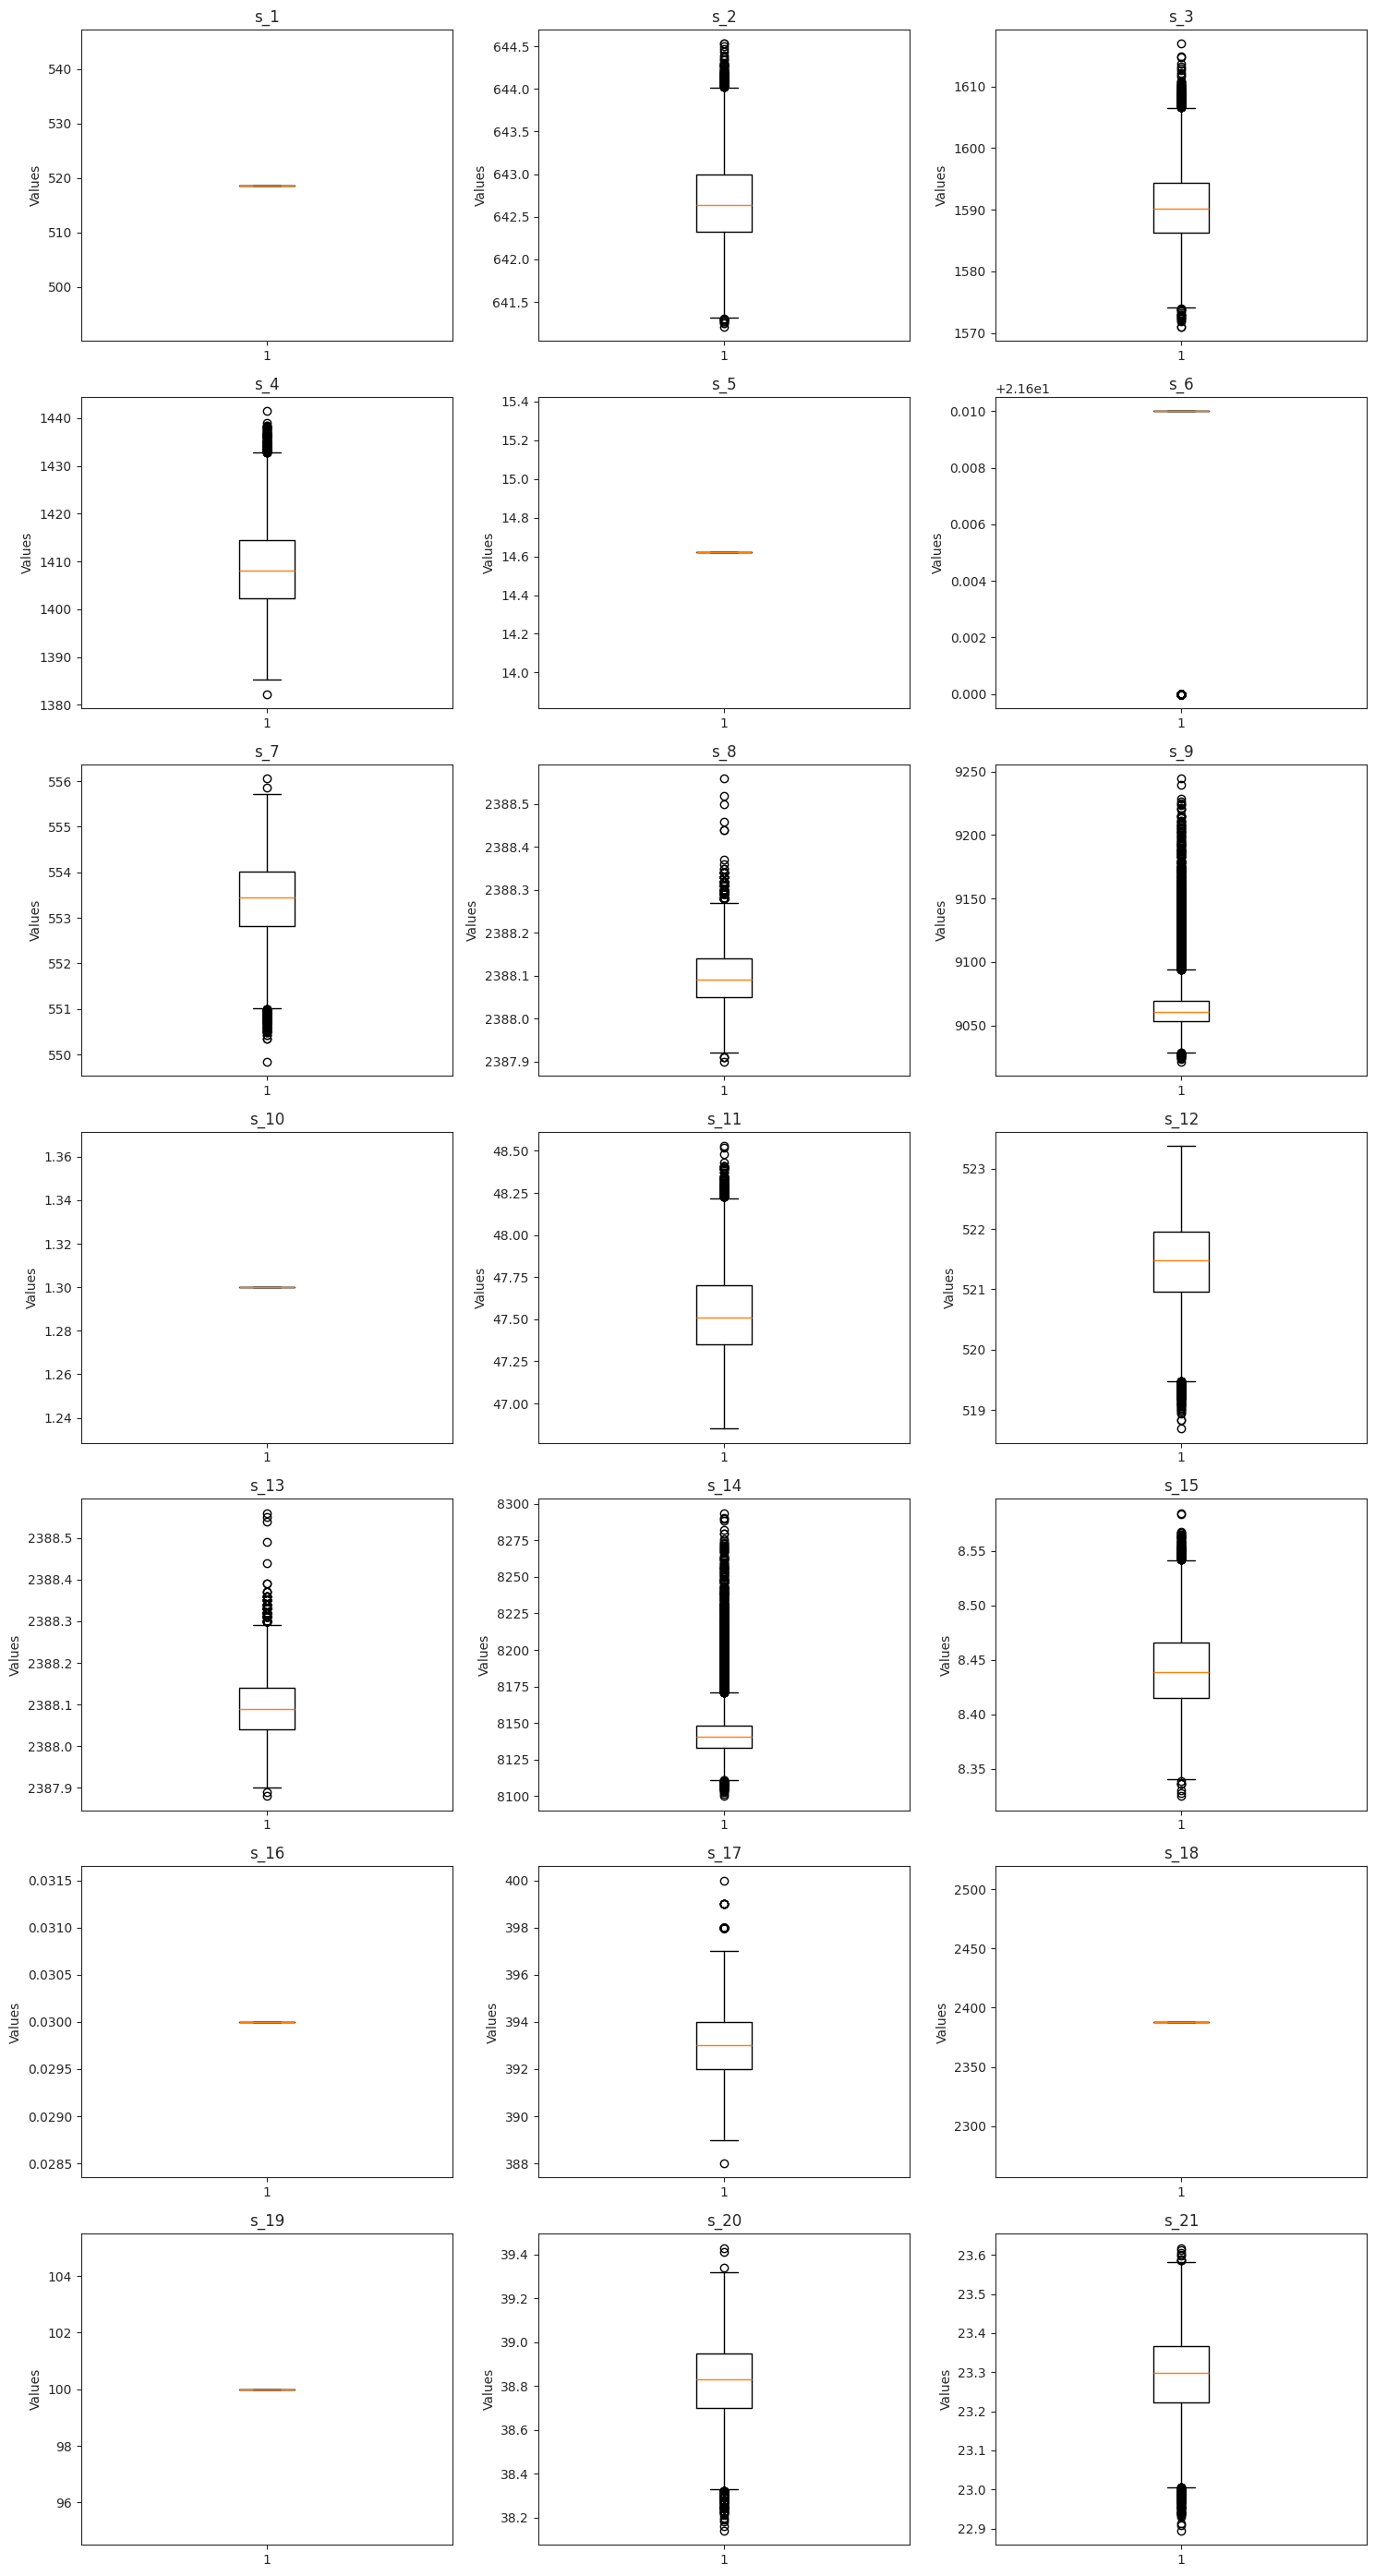

In [24]:
plot_boxplots(fd001_treino, nomes_sensores)

By analyzing the boxplots above, it is evident that sensors 1, 5, 10, 16, 18, and 19 exhibit constant signals. Additionally, the remaining sensors do not show well-distributed data and contain many outliers.

It is also clear that the sensor signals do not share the same scale and do not follow a normal distribution. To address these issues, the data will be normalized.

___________

Criando a coluna RUL no conjunto de testes

In [25]:
RUL_treino = fd001_treino.groupby('id_unidade')['tempo_ciclos'].max().reset_index()
RUL_treino.rename(columns={'tempo_ciclos':'RUL_max'}, inplace=True)
fd001_treino = fd001_treino.merge(RUL_treino, on='id_unidade', how='left')
fd001_treino['RUL']=fd001_treino['RUL_max']-fd001_treino['tempo_ciclos']

Criando a coluna RUL no conjunto de validação

In [26]:
# Renaming the target variable
fd001_rul.rename(columns={'ciclos_restantes':'RUL_sobra'}, inplace=True)
fd001_rul['id_unidade'] = fd001_rul.index + 1
# Merging the two DataFrames to bring the RUL value for each unit
fd001_valid = fd001_valid.merge(fd001_rul, on='id_unidade', how='left')
# Getting the maximum cycle count for each unit in the validation DataFrame
max_ciclos = fd001_valid.groupby('id_unidade')['tempo_ciclos'].transform('max')
# Adding the new 'ciclo_max' column to the original DataFrame
fd001_valid['ciclo_max'] = max_ciclos
fd001_valid['RUL'] = (fd001_valid['ciclo_max']+fd001_valid['RUL_sobra'])-fd001_valid['tempo_ciclos']

Criando classificações no conjunto de teste e treino.

In [27]:
def classificar(df):
    y=[]
    # Converting RUL values into classifications
    for k in df['RUL']:
        if k<=50:
            y.append(1)
        else:
            y.append(0)
    return y

fd001_treino['Risco'] = classificar(fd001_treino)
fd001_valid['Risco'] = classificar(fd001_valid)

In [28]:
df_treino = fd001_treino.copy()
df_valid = fd001_valid.copy()

#### Normalizar dados

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Normalizing data with MinMaxScaler
df_treino_norm = df_treino.copy()
df_treino_norm[nomes_sensores+nomes_configuracoes] = scaler.fit_transform(df_treino_norm[nomes_sensores+nomes_configuracoes])

df_valid_norm = df_valid.copy()
df_valid_norm[nomes_sensores+nomes_configuracoes] = scaler.fit_transform(df_valid_norm[nomes_sensores+nomes_configuracoes])

### Remover colunas únicas e altamente correlacionadas

Removendo colunas com sensores constantes e correlacionados

In [30]:
remover_colunas = ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19', 'config_3']
# Creating a new list without the elements above
nomes_sensores_sc = []
for sensor in nomes_sensores+nomes_configuracoes:
    if sensor not in remover_colunas:
        nomes_sensores_sc.append(sensor)

df_treino_sc = df_treino_norm.drop(remover_colunas, axis=1)
df_valid_sc = df_valid_norm.drop(remover_colunas, axis=1)

In [31]:
df_treino_sc.shape

(20631, 22)

### Aplicar tratamento dos ruídos utilizando média móvel

In [32]:
window_size = 3
df_treino_mm = df_treino_sc.copy()
df_valid_mm = df_valid_sc.copy()
nomes_sensores_mm = []
for coluna in nomes_sensores_sc:
    nome_coluna_mm = coluna + '_moving_avg'
    nomes_sensores_mm.append(nome_coluna_mm)
    df_treino_mm[coluna + '_moving_avg'] = df_treino_mm[coluna].rolling(window=window_size).mean()
    df_valid_mm[coluna + '_moving_avg'] = df_valid_mm[coluna].rolling(window=window_size).mean()
    # Changing NaNs with original values
    df_treino_mm[nome_coluna_mm].fillna(df_treino_mm[coluna], inplace=True)
    df_valid_mm[nome_coluna_mm].fillna(df_valid_mm[coluna], inplace=True)

In [33]:
nomes_sensores_mm = ['s_2_moving_avg', 's_3_moving_avg', 's_4_moving_avg',
       's_6_moving_avg', 's_7_moving_avg', 's_8_moving_avg', 's_9_moving_avg',
       's_11_moving_avg', 's_12_moving_avg', 's_13_moving_avg',
       's_14_moving_avg', 's_15_moving_avg', 's_17_moving_avg',
       's_20_moving_avg', 's_21_moving_avg', 'config_1_moving_avg',
       'config_2_moving_avg']

### Aplicar o PCA para redução de dimensionalidade

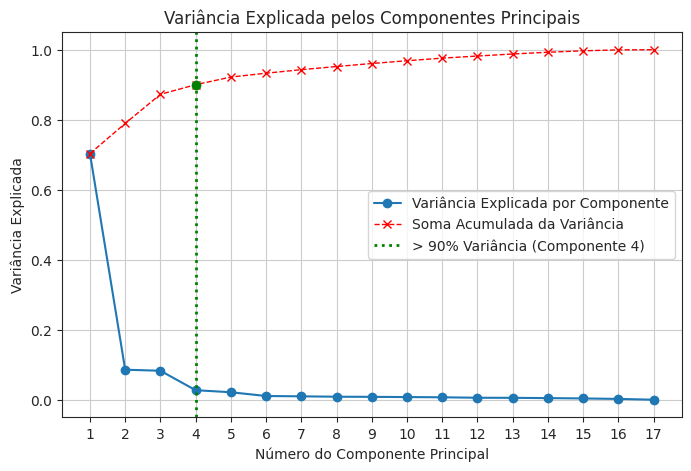

In [34]:
from sklearn.decomposition import PCA

X = df_treino_mm[nomes_sensores_mm]

# Constructing PCA
pca = PCA(n_components=min(X.shape))
X_pca = pca.fit_transform(X)

# Calculating the cumulative sum of explained variance
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

# Finding the point where cumulative explained variance exceeds 90%
threshold_index = np.where(cumsum_variance >= 0.90)[0][0] + 1

# Visualizing the explained variance by principal components
plt.figure(figsize=(8, 5))

# Plotting the explained variance for each component
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_,
         marker='o', linestyle='-', label='Variância Explicada por Componente')

# Adding the curve for cumulative explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumsum_variance,
         marker='x', linestyle='--', color='red', linewidth=1, label='Soma Acumulada da Variância')

# Highlighting the point where cumulative variance exceeds 90%
plt.axvline(x=threshold_index, color='green', linestyle=':', linewidth=2, label=f'> 90% Variância (Componente {threshold_index})')
plt.scatter(threshold_index, cumsum_variance[threshold_index-1], color='green', zorder=5)

# Plot configuration
plt.title('Variância Explicada pelos Componentes Principais')
plt.xlabel('Número do Componente Principal')
plt.ylabel('Variância Explicada')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1, 1))
plt.grid()
plt.legend()
plt.show()

# Displaying the principal components
#components_df = pd.DataFrame(data=pca.components_, columns=nomes_sensores_sc,
#index=[f'PC{i + 1}' for i in range(len(pca.components_))])
#print("Componentes Principais:")
#print(components_df)

In [35]:
cumsum_variance

array([0.70332461, 0.78946224, 0.87257291, 0.90016922, 0.92194856,
       0.93295242, 0.94303203, 0.95201005, 0.96061352, 0.96859089,
       0.97594814, 0.98197411, 0.98778513, 0.99283057, 0.99686634,
       0.9995964 , 1.        ])

In [36]:
# Constructing PCA
pca = PCA(n_components=4)  # Selecting 4 principal components
X_pca = pca.fit_transform(X)

# Creating DataFrame with factor loadings (principal components)
components_df = pd.DataFrame(data=pca.components_, columns=nomes_sensores_sc,
                             index=[f'PC{i + 1}' for i in range(pca.n_components_)])

# Calculating h² (communality) for each variable
# h² is the sum of squared factor loadings for each variable
components_squared = components_df ** 2
h2 = components_squared.sum(axis=0)

# Creating DataFrame with factor loadings and h²
components_with_h2 = components_df.T
components_with_h2['h^2'] = h2

# Displaying the table
print("Contribuição das variáveis para as 8 componentes principais e o h^2:")
components_with_h2

Contribuição das variáveis para as 8 componentes principais e o h^2:


,PC1,PC2,PC3,PC4,h^2
s_2,0.290517,-0.027557,0.014332,0.002984,0.085374
s_3,0.242891,-0.072537,0.066831,-0.024609,0.069330
s_4,0.326235,-0.013867,0.014658,-0.018961,0.107196
s_6,0.058768,0.046330,-0.027073,0.996279,0.998905
s_7,-0.303135,-0.046134,0.048299,0.017167,0.096647
s_8,0.216112,0.174953,-0.177496,-0.025905,0.109489
s_9,0.072392,-0.447366,0.453283,0.031911,0.411861
s_11,0.352705,0.009606,-0.017018,-0.018516,0.125126
s_12,-0.343202,-0.060597,0.070878,0.027932,0.127264
s_13,0.212175,0.172501,-0.176598,-0.015897,0.106214


Componentes Principais:
     s_2_moving_avg  s_3_moving_avg  s_4_moving_avg  s_6_moving_avg  \
PC1        0.290517        0.242891        0.326235        0.058768   
PC2       -0.027557       -0.072537       -0.013867        0.046330   
PC3        0.014332        0.066831        0.014658       -0.027073   
PC4        0.002984       -0.024609       -0.018961        0.996279   

     s_7_moving_avg  s_8_moving_avg  s_9_moving_avg  s_11_moving_avg  \
PC1       -0.303135        0.216112        0.072392         0.352705   
PC2       -0.046134        0.174953       -0.447366         0.009606   
PC3        0.048299       -0.177496        0.453283        -0.017018   
PC4        0.017167       -0.025905        0.031911        -0.018516   

     s_12_moving_avg  s_13_moving_avg  s_14_moving_avg  s_15_moving_avg  \
PC1        -0.343202         0.212175         0.043922         0.293698   
PC2        -0.060597         0.172501        -0.460538        -0.024071   
PC3         0.070878        -0.176

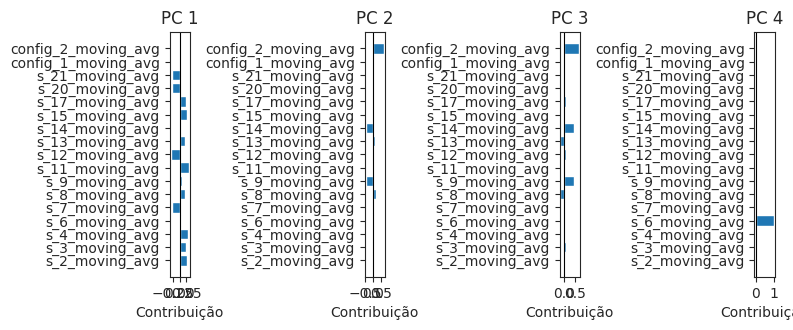

Variáveis a serem mantidas: ['s_14_moving_avg', 's_9_moving_avg', 's_4_moving_avg', 'config_2_moving_avg', 's_6_moving_avg', 's_21_moving_avg', 's_11_moving_avg', 's_7_moving_avg', 's_12_moving_avg']


In [37]:
# Applying PCA and keeping 4 principal components
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

# Applying PCA and keeping 4 principal components
components_df = pd.DataFrame(data=pca.components_, columns=X.columns,
                             index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("Componentes Principais:")
print(components_df)

# Visualizing each variable's contribution to the principal components
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.barh(components_df.columns, components_df.iloc[i])
    plt.title(f'PC {i + 1}')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.xlabel('Contribuição')
plt.tight_layout()
plt.show()

# Analyzing which variables to keep
limiar = 0.3
variaveis_mantidas = []
for i in range(4):
    contribuições = components_df.iloc[i]
    variaveis_significativas = contribuições[abs(contribuições) > limiar].index.tolist()
    variaveis_mantidas.extend(variaveis_significativas)

# Removing duplicates
variaveis_mantidas = list(set(variaveis_mantidas))
print("Variáveis a serem mantidas:", variaveis_mantidas)

In [38]:
colunas_pca = ['s_9_moving_avg', 's_12_moving_avg', 's_11_moving_avg', 's_6_moving_avg',
               's_4_moving_avg', 'config_2_moving_avg', 's_21_moving_avg', 's_14_moving_avg', 's_7_moving_avg']
colunas_pca_indices = ['id_unidade', 'Risco']

df_treino_pca = df_treino_mm[colunas_pca+colunas_pca_indices]
df_valid_pca = df_valid_mm[colunas_pca+colunas_pca_indices]

In [39]:
# Getting the component matrix
components_df = pd.DataFrame(data=pca.components_, columns=X.columns, index=[f'PC{i + 1}' for i in range(pca.n_components_)])

# Calculating h² for each principal component
h_squared = np.sum(components_df**2, axis=1)
components_df['h^2'] = h_squared

# Displaying the table with h²
components_df

,s_2_moving_avg,s_3_moving_avg,s_4_moving_avg,s_6_moving_avg,s_7_moving_avg,s_8_moving_avg,s_9_moving_avg,s_11_moving_avg,s_12_moving_avg,s_13_moving_avg,s_14_moving_avg,s_15_moving_avg,s_17_moving_avg,s_20_moving_avg,s_21_moving_avg,config_1_moving_avg,config_2_moving_avg,h^2
PC1,0.290517,0.242891,0.326235,0.058768,-0.303135,0.216112,0.072392,0.352705,-0.343202,0.212175,0.043922,0.293698,0.243297,-0.279596,-0.300018,0.002063,0.010380,1.0
PC2,-0.027557,-0.072537,-0.013867,0.046330,-0.046134,0.174953,-0.447366,0.009606,-0.060597,0.172501,-0.460538,-0.024071,-0.070743,0.021818,0.031844,0.004698,0.711375,1.0
PC3,0.014332,0.066831,0.014658,-0.027073,0.048299,-0.177496,0.453283,-0.017018,0.070878,-0.176598,0.468041,0.025891,0.065739,-0.021046,-0.023575,-0.004149,0.702500,1.0
PC4,0.002984,-0.024609,-0.018961,0.996279,0.017167,-0.025905,0.031911,-0.018516,0.027932,-0.015897,0.034368,-0.012704,-0.008431,0.018697,0.031996,-0.009732,-0.014573,1.0


### Aplicando dendograma para avaliar similaridade

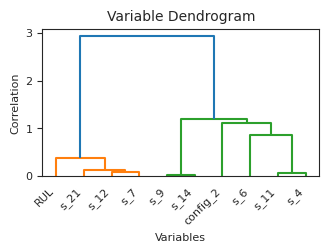

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Concatenating training variables with target 'y_treino_den'
X_treino_den = df_treino_pca[['s_9_moving_avg', 's_12_moving_avg', 's_11_moving_avg',
       's_6_moving_avg', 's_4_moving_avg', 'config_2_moving_avg',
       's_21_moving_avg', 's_14_moving_avg', 's_7_moving_avg']]
y_treino_den = df_treino_sc['RUL']
df_dendrograma = pd.concat([X_treino_den, y_treino_den], axis=1)

# Calculating the correlation matrix
correlation_matrix = df_dendrograma.corr()

# Converting the correlation matrix into a distance matrix
distance_matrix = 1 - correlation_matrix

# Applying linkage to generate the dendrogram
Z = linkage(squareform(distance_matrix), method='ward')

# Creating a list of labels without "_moving_avg"
labels = [col.replace('_moving_avg', '') for col in df_dendrograma.columns]

# Convert 88.9 mm to inches (~3.5 inches)
width_inches = 88.9 / 25.4
height_inches = width_inches * 0.75  # Maintain aspect ratio

# Create and save the dendrogram
plt.figure(figsize=(width_inches, height_inches))  # Set figure size
dendrogram(Z, labels=labels)

# Customize fonts
title_fontsize = 10
axis_fontsize = 8
tick_fontsize = 8

plt.title('Variable Dendrogram', fontsize=title_fontsize)
plt.xlabel('Variables', fontsize=axis_fontsize)
plt.ylabel('Correlation', fontsize=axis_fontsize)

# Rotating X-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.tight_layout()

# Show the plot
plt.show()


In [41]:
colunas_selecionadas = ['s_21_moving_avg','s_12_moving_avg','s_7_moving_avg']

#### Dividindo conjunto de treinamento em treino e teste

In [42]:
# Creating a list of time series identifiers
unidades = df_treino_pca['id_unidade'].unique()

# Splitting the identifiers into training and testing sets
treino_ids, teste_ids = train_test_split(unidades, test_size=0.2, random_state=42)

# Filtering the training and testing datasets
df_treino = df_treino_pca[df_treino_pca['id_unidade'].isin(treino_ids)]
df_teste = df_treino_pca[df_treino_pca['id_unidade'].isin(teste_ids)]
df_valid = df_valid_pca

In [43]:
# Check to ensure that no time series is split across training and testing sets
train_series_ids = set(df_treino['id_unidade'].unique())
test_series_ids = set(df_teste['id_unidade'].unique())

intersection = train_series_ids.intersection(test_series_ids)
if len(intersection) == 0:
    print("Successful check: no series is split between training and testing sets.")
else:
    print(f"Error: The following series are split between training and testing sets: {intersection}")

Successful check: no series is split between training and testing sets.


### Balanceando as classes

In [44]:
classe_1 = df_treino[df_treino['Risco']==0].shape[0]
classe_2 = df_treino[df_treino['Risco']==1].shape[0]

print(f'The number of observations in class 1 is {classe_1} and in class 2 is'
f'{classe_2}, with a ratio of approximately {round(classe_1/classe_2)} to 1.')

The number of observations in class 1 is 12481 and in class 2 is4080, with a ratio of approximately 3 to 1.


In [45]:
from imblearn.over_sampling import SMOTE

X_treino = df_treino[colunas_selecionadas]
y_treino = np.array(df_treino['Risco'])

# Applying SMOTE
smote = SMOTE(random_state=42)
X_treino_res, y_treino_res = smote.fit_resample(X_treino, y_treino)

# Showing new class distribution after SMOTE
from collections import Counter
print(f"Original class distribution: {Counter(y_treino)}")
print(f"New class distribution: {Counter(y_treino_res)}")

Original class distribution: Counter({np.int64(0): 12481, np.int64(1): 4080})
New class distribution: Counter({np.int64(0): 12481, np.int64(1): 12481})


### Aplicando regressao logistica

In [46]:
df_treino

,s_9_moving_avg,s_12_moving_avg,s_11_moving_avg,s_6_moving_avg,s_4_moving_avg,config_2_moving_avg,s_21_moving_avg,s_14_moving_avg,s_7_moving_avg,id_unidade,Risco
192,0.097984,0.420043,0.551587,0.666667,0.548616,0.555556,0.400580,0.109127,0.383790,2,0
193,0.110772,0.642502,0.371032,0.666667,0.364956,0.583333,0.528998,0.137475,0.590446,2,0
194,0.142212,0.820185,0.166667,0.333333,0.206054,0.666667,0.740771,0.188478,0.799249,2,0
195,0.147133,0.831557,0.200397,0.666667,0.233063,0.388889,0.761116,0.193157,0.784219,2,0
196,0.157363,0.800995,0.202381,0.333333,0.285899,0.583333,0.767974,0.202756,0.803006,2,0
...,...,...,...,...,...,...,...,...,...,...,...
20626,0.207709,0.190476,0.765873,1.000000,0.794452,0.472222,0.283347,0.207022,0.283951,100,1
20627,0.202115,0.199716,0.750000,1.000000,0.829169,0.250000,0.295775,0.201569,0.223296,100,1
20628,0.196446,0.221038,0.724206,1.000000,0.808238,0.277778,0.176563,0.198386,0.197531,100,1
20629,0.208711,0.233831,0.787698,1.000000,0.796421,0.444444,0.218218,0.201294,0.157273,100,1


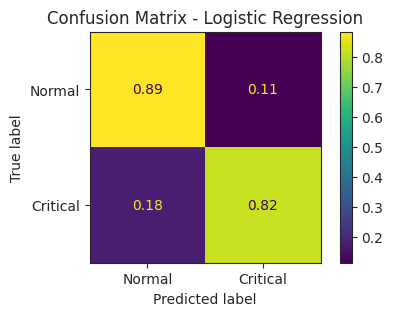


Evaluation Metrics:
Training set accuracy: 0.9074
Training set precision: 0.9055
Training set F1 score: 0.9050
Test set accuracy: 0.9103
Test set precision: 0.9087
Test set F1 score: 0.9090
Validation set accuracy: 0.8807
Validation set precision: 0.9418
Validation set F1 score: 0.9021


In [47]:
# Label mapping
label_map = {1: 'Critical', 0: 'Normal'}

# Logistic Regression model hyperparameters
solver = 'liblinear'  # Optimization algorithm
random_state = 42  # Random state to ensure reproducibility

# Preparing the data
X_teste = df_teste[colunas_selecionadas]
y_teste = np.array(df_teste['Risco'])

X_valid = df_valid[colunas_selecionadas]
y_valid = np.array(df_valid['Risco'])

# Defining the model with specified hyperparameters
logistic_classifier = LogisticRegression(solver=solver, penalty='l2', C=0.8, random_state=random_state)

# Training the model
logistic_classifier.fit(X_treino, y_treino)

# Evaluating the model on the training set
y_pred_treino = logistic_classifier.predict(X_treino)
# Evaluating the model on the test set
y_pred_teste = logistic_classifier.predict(X_teste)
# Evaluating the model on the validation set
y_pred_valid = logistic_classifier.predict(X_valid)

# Ensuring predicted labels match the format of actual labels
unique_labels = np.unique(np.concatenate((y_valid, y_pred_valid)))

# Creating the confusion matrix
cm = confusion_matrix(y_valid, y_pred_valid, labels=unique_labels, normalize='true')
fig, ax = plt.subplots(figsize=(5, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[label_map[label] for label in unique_labels])
disp.plot(ax=ax)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

logistic_treino_acc_1 = accuracy_score(y_treino, y_pred_treino)
logistic_teste_acc_1 = accuracy_score(y_teste, y_pred_teste)
logistic_valid_acc_1 = accuracy_score(y_valid, y_pred_valid)

logistic_treino_f1_1 = f1_score(y_treino, y_pred_treino, average='weighted')
logistic_teste_f1_1 = f1_score(y_teste, y_pred_teste, average='weighted')
logistic_valid_f1_1 = f1_score(y_valid, y_pred_valid, average='weighted')

logistic_treino_precision_1 = precision_score(y_treino, y_pred_treino, average='weighted')
logistic_teste_precision_1 = precision_score(y_teste, y_pred_teste, average='weighted')
logistic_valid_precision_1 = precision_score(y_valid, y_pred_valid, average='weighted')


print("\nEvaluation Metrics:")
print(f"Training set accuracy: {logistic_treino_acc_1:.4f}")
print(f"Training set precision: {logistic_treino_precision_1:.4f}")
print(f"Training set F1 score: {logistic_treino_f1_1:.4f}")

print(f"Test set accuracy: {logistic_teste_acc_1:.4f}")
print(f"Test set precision: {logistic_teste_precision_1:.4f}")
print(f"Test set F1 score: {logistic_teste_f1_1:.4f}")

print(f"Validation set accuracy: {logistic_valid_acc_1:.4f}")
print(f"Validation set precision: {logistic_valid_precision_1:.4f}")
print(f"Validation set F1 score: {logistic_valid_f1_1:.4f}")

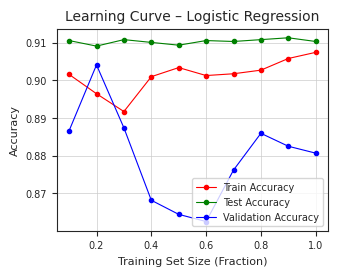

In [48]:
def plot_learning_curve_custom(X_treino, y_treino, X_teste, y_teste, X_valid, y_valid, logistic_classifier, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_scores = []
    test_scores = []
    valid_scores = []

    for train_size in train_sizes:
        # Reduce the training set according to the specified fraction
        X_train_partial = X_treino[:int(len(X_treino) * train_size)]
        y_train_partial = y_treino[:int(len(y_treino) * train_size)]

        # Retrain the model with the reduced fraction
        logistic_classifier.fit(X_train_partial, y_train_partial)

        # Calculate accuracy on training, test, and validation sets
        train_scores.append(accuracy_score(y_train_partial, logistic_classifier.predict(X_train_partial)))
        test_scores.append(accuracy_score(y_teste, logistic_classifier.predict(X_teste)))
        valid_scores.append(accuracy_score(y_valid, logistic_classifier.predict(X_valid)))

    # Converting measurements to inches
    width_inches = 88.9 / 25.4
    height_inches = width_inches * 0.75  # Adjusting aspect ratio

    # Creating figure
    plt.figure(figsize=(width_inches, height_inches))

    # Learning curves with thinner lines and smaller markers
    plt.plot(train_sizes, train_scores, 'o-', color="r", linewidth=0.8, markersize=3, label="Train Accuracy")
    plt.plot(train_sizes, test_scores, 'o-', color="g", linewidth=0.8, markersize=3, label="Test Accuracy")
    plt.plot(train_sizes, valid_scores, 'o-', color="b", linewidth=0.8, markersize=3, label="Validation Accuracy")

    # Graph configuration
    plt.title("Learning Curve – Logistic Regression", fontsize=10)
    plt.xlabel("Training Set Size (Fraction)", fontsize=8)
    plt.ylabel("Accuracy", fontsize=8)
    plt.legend(loc="best", fontsize=7)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.grid(True, linewidth=0.5)  # Making the grid more subtle

    # Display the plot
    plt.show()

# Calling the function
plot_learning_curve_custom(X_treino, y_treino, X_teste, y_teste, X_valid, y_valid, logistic_classifier)


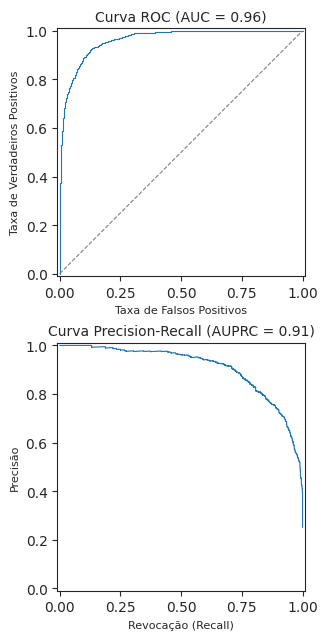

In [49]:
# Generating class probabilities
y_scores_teste = logistic_classifier.predict_proba(X_teste)[:, 1]  # Positive class prob.

# Figure configuration
width_inches = 88.8 / 25.4
height_inches = width_inches * 1.8

# Creating a figure with two plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width_inches, height_inches), constrained_layout=True)

# === ROC curve ===
fpr, tpr, _ = roc_curve(y_teste, y_scores_teste)
roc_auc = auc(fpr, tpr)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
roc_display.plot(ax=ax1, linewidth=0.8)  # Thinner lines
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=0.8)  # Reference line
ax1.set_title(f'Curva ROC (AUC = {roc_auc:.2f})', fontsize=10)
ax1.set_xlabel('Taxa de Falsos Positivos', fontsize=8)
ax1.set_ylabel('Taxa de Verdadeiros Positivos', fontsize=8)
ax1.legend([], [], frameon=False)  # Remove legend

# === Precision-Recall curve ===
precision, recall, _ = precision_recall_curve(y_teste, y_scores_teste)
pr_auc = auc(recall, precision)

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='Logistic Regression')
pr_display.plot(ax=ax2, linewidth=0.8)  # Thinner lines
ax2.set_title(f'Curva Precision-Recall (AUPRC = {pr_auc:.2f})', fontsize=10)
ax2.set_xlabel('Revocação (Recall)', fontsize=8)
ax2.set_ylabel('Precisão', fontsize=8)
ax2.legend([], [], frameon=False)  # Remove legend

plt.show()


#### Aplicanto SVC

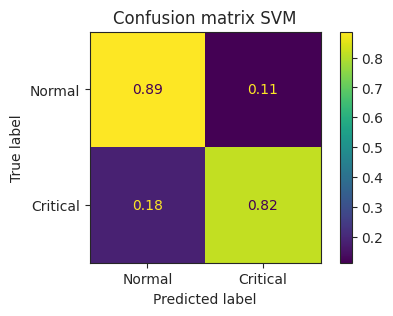


Evaluation Metrics - SVM:
Training set accuracy: 0.9071
Training set precision: 0.9051
Training set F1 score: 0.9048
Test set accuracy: 0.9091
Test set precision: 0.9075
Test set F1 score: 0.9078
Validation set accuracy: 0.8819
Validation set precision: 0.9417
Validation set F1 score: 0.9029


In [50]:
# Tag mapping
label_map = {1: 'Critical', 0: 'Normal'}

# SVM hyperparameters
kernel = 'linear'
C = 1.0
random_state = 42

# Data preparation
X_teste = df_teste[colunas_selecionadas]
y_teste = np.array(df_teste['Risco'])

X_valid = df_valid[colunas_selecionadas]
y_valid = np.array(df_valid['Risco'])

# Defining SVM
svm_classifier = SVC(kernel=kernel, C=C, random_state=random_state)

# Training model
svm_classifier.fit(X_treino, y_treino)

# Evaluating the model on the training set
y_pred_treino_svm = svm_classifier.predict(X_treino)
# Evaluating the model on the test set
y_pred_teste_svm = svm_classifier.predict(X_teste)
# Evaluating the model on the validation set
y_pred_valid_svm = svm_classifier.predict(X_valid)

# Creating the confusion matrix
cm_svm = confusion_matrix(y_valid, y_pred_valid_svm, normalize='true')
fig, ax = plt.subplots(figsize=(5, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm,
                              display_labels=[label_map[label] for label in np.unique(y_valid)])
disp.plot(ax=ax)
plt.title('Confusion matrix SVM')
plt.show()

# Calculating evaluation metrics for the SVM model
svm_treino_acc = accuracy_score(y_treino, y_pred_treino_svm)
svm_teste_acc = accuracy_score(y_teste, y_pred_teste_svm)
svm_valid_acc = accuracy_score(y_valid, y_pred_valid_svm)

svm_treino_f1 = f1_score(y_treino, y_pred_treino_svm, average='weighted')
svm_teste_f1 = f1_score(y_teste, y_pred_teste_svm, average='weighted')
svm_valid_f1 = f1_score(y_valid, y_pred_valid_svm, average='weighted')

svm_treino_precision = precision_score(y_treino, y_pred_treino_svm, average='weighted')
svm_teste_precision = precision_score(y_teste, y_pred_teste_svm, average='weighted')
svm_valid_precision = precision_score(y_valid, y_pred_valid_svm, average='weighted')

# Displaying the evaluation metrics
print("\nEvaluation Metrics - SVM:")
print(f"Training set accuracy: {svm_treino_acc:.4f}")
print(f"Training set precision: {svm_treino_precision:.4f}")
print(f"Training set F1 score: {svm_treino_f1:.4f}")

print(f"Test set accuracy: {svm_teste_acc:.4f}")
print(f"Test set precision: {svm_teste_precision:.4f}")
print(f"Test set F1 score: {svm_teste_f1:.4f}")

print(f"Validation set accuracy: {svm_valid_acc:.4f}")
print(f"Validation set precision: {svm_valid_precision:.4f}")
print(f"Validation set F1 score: {svm_valid_f1:.4f}")

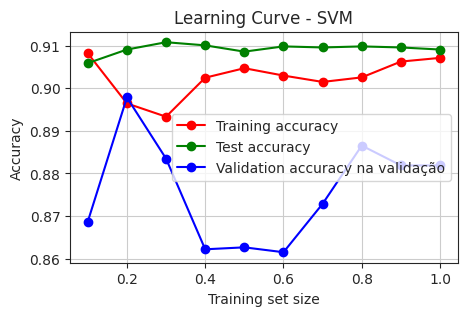

In [51]:
# Function to generate learning curves based on precomputed predictions
def plot_learning_curve_custom_svm(X_treino, y_treino, X_teste, y_teste, X_valid,
                                   y_valid, svm_classifier, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_scores = []
    test_scores = []
    valid_scores = []

    for train_size in train_sizes:
        # Reduce the training set according to the specified size
        X_train_partial = X_treino[:int(len(X_treino) * train_size)]
        y_train_partial = y_treino[:int(len(y_treino) * train_size)]

        # Retrain the model with the fraction of training data
        svm_classifier.fit(X_train_partial, y_train_partial)

        # Accuracy on the training set
        y_pred_train_partial = svm_classifier.predict(X_train_partial)
        train_acc = accuracy_score(y_train_partial, y_pred_train_partial)
        train_scores.append(train_acc)

        # Accuracy on the test set
        y_pred_test_partial = svm_classifier.predict(X_teste)
        test_acc = accuracy_score(y_teste, y_pred_test_partial)
        test_scores.append(test_acc)

        # Accuracy on the validation set
        y_pred_valid_partial = svm_classifier.predict(X_valid)
        valid_acc = accuracy_score(y_valid, y_pred_valid_partial)
        valid_scores.append(valid_acc)

    # Plotting the learning curves
    plt.figure(figsize=(5, 3))

    # Training curve
    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training accuracy")

    # Test curve
    plt.plot(train_sizes, test_scores, 'o-', color="g", label="Test accuracy ")

    # Validation curve
    plt.plot(train_sizes, valid_scores, 'o-', color="b", label="Validation accuracy na validação")

    # Configuring the plot
    plt.title("Learning Curve - SVM")
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Calling function
plot_learning_curve_custom_svm(X_treino, y_treino, X_teste, y_teste, X_valid, y_valid, svm_classifier)

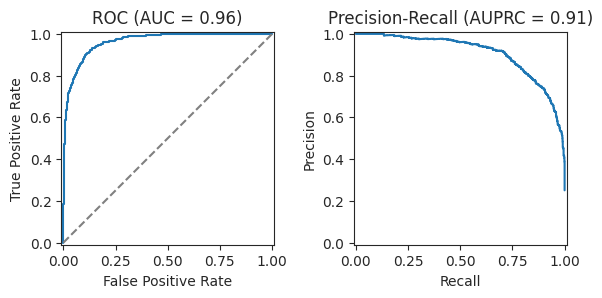

In [52]:
# Generate predicted probabilities
y_scores_teste_svm = svm_classifier.decision_function(X_teste)

# Plotting ROC and Precision-Recall curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_teste, y_scores_teste_svm)
roc_auc_svm = auc(fpr, tpr)

# ROC curve plot
roc_display_svm = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_svm, estimator_name='SVM')
roc_display_svm.plot(ax=ax1)
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line
ax1.set_title(f'ROC (AUC = {roc_auc_svm:.2f})')

# Remove legend from ROC curve
ax1.legend([], [], frameon=False)

# === Precision-Recall Curve ===
precision_svm, recall_svm, _ = precision_recall_curve(y_teste, y_scores_teste_svm)
pr_auc_svm = auc(recall_svm, precision_svm)

# Precision-Recall curve plot
pr_display_svm = PrecisionRecallDisplay(precision=precision_svm, recall=recall_svm, estimator_name='SVM')
pr_display_svm.plot(ax=ax2)
ax2.set_title(f'Precision-Recall (AUPRC = {pr_auc_svm:.2f})')

# Remove legend from PR curve
ax2.legend([], [], frameon=False)

# Display the plot
plt.tight_layout()
plt.show()

### Aplicando LGBM

In [53]:
import xgboost as xgb

X_teste = df_teste[colunas_selecionadas].values
y_teste = np.array(df_teste['Risco'])

X_valid = df_valid[colunas_selecionadas].values
y_valid = np.array(df_valid['Risco'])

# Initializing the XGBoost model
xgb_classifier = xgb.XGBClassifier(n_estimators=725, n_jobs=-1)

# Defining the hyperparameter search space
params = {
    'learning_rate': np.arange(0.01, 0.11, 0.025),
    'max_depth': np.arange(1, 10, 1),
    'min_child_weight': np.arange(1, 10, 1),
    'subsample': np.arange(0.7, 1, 0.05),
    'gamma': np.arange(0.5, 1, 0.1),
    'colsample_bytree': np.arange(0.1, 1, 0.05),
    'scale_pos_weight': np.arange(20, 200, 10)
}

# Defining the stratified cross-validation strategy
stf_kf = StratifiedKFold(n_splits=5)
# Setting up RandomizedSearchCV
rs_cv_classifier = RandomizedSearchCV(xgb_classifier, param_distributions=params, cv=stf_kf, n_jobs=-1)
# Fitting the model with the training data
rs_cv_classifier.fit(X_treino, y_treino)
# Making predictions on the test set
y_pred = rs_cv_classifier.predict(X_valid)
# Displaying the best parameters found
print("Best Parameters: \n", rs_cv_classifier.best_params_)
# Calculating and displaying test set accuracy
print("XGBClassifier Acc Score: ", accuracy_score(y_pred, y_valid))

Best Parameters: 
 {'subsample': np.float64(0.9000000000000001), 'scale_pos_weight': np.int64(140), 'min_child_weight': np.int64(4), 'max_depth': np.int64(6), 'learning_rate': np.float64(0.035), 'gamma': np.float64(0.7999999999999999), 'colsample_bytree': np.float64(0.8500000000000002)}
XGBClassifier Acc Score:  0.568417837507636


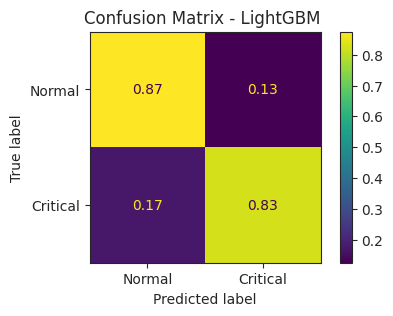


Evaluation Metrics :
Training set accuracy: 0.9060
Training set precision: 0.9044
Training set F1 score: 0.9027
Test set accuracy: 0.9113
Test set precision: 0.9096
Test set F1 score: 0.9092
Validation set accuracy: 0.8710
Validation set precision: 0.9409
Validation set F1 score: 0.8954


In [54]:
import lightgbm as lgb

label_map = {1: 'Critical', 0: 'Normal'}

# Preparing data
X_teste = df_teste[colunas_selecionadas].values
y_teste = np.array(df_teste['Risco'])

X_valid = df_valid[colunas_selecionadas].values
y_valid = np.array(df_valid['Risco'])

# Encoding labels
encoder = LabelEncoder()
y_treino_encoded = encoder.fit_transform(y_treino)
y_teste_encoded = encoder.transform(y_teste)
y_valid_encoded = encoder.transform(y_valid)

# Tuning hyperparameters to avoid overfitting
lgb_clss = lgb.LGBMClassifier(
    max_depth=50,
    num_leaves=15,
    bagging_fraction=0.7,       # Use 70% of the data in each tree
    feature_fraction=0.7,       # Use 70% of the features in each tree
    lambda_l1=0.1,
    lambda_l2=0.1,
    learning_rate=0.01,
    n_estimators=200,           # Increase the number of trees
    verbosity=-1                # Control verbosity (-1 to silence output)
)

# Adding validation and early stopping
lgb_clss.fit(
    X_treino,
    y_treino_encoded,
    eval_set=[(X_valid, y_valid_encoded)],
)

# Making predictions on the validation set
y_pred_valid = lgb_clss.predict(X_valid)

# Getting all classes present in predicted and actual labels
unique_labels = np.unique(np.concatenate((y_valid_encoded, y_pred_valid)))

# Creating the confusion matrix
cm = confusion_matrix(y_valid_encoded, y_pred_valid, labels=unique_labels, normalize='true')
fig, ax = plt.subplots(figsize=(5, 3))

# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[label] for label in encoder.inverse_transform(unique_labels)])
disp.plot(ax=ax)
plt.title('Confusion Matrix - LightGBM ')
plt.show()

# Calculating evaluation metrics
lgb_treino_acc = accuracy_score(y_treino_encoded, lgb_clss.predict(X_treino))
lgb_treino_f1 = f1_score(y_treino_encoded, lgb_clss.predict(X_treino), average='weighted')
lgb_treino_precision = precision_score(y_treino_encoded, lgb_clss.predict(X_treino), average='weighted')

lgb_teste_acc = accuracy_score(y_teste_encoded, lgb_clss.predict(X_teste))
lgb_teste_f1 = f1_score(y_teste_encoded, lgb_clss.predict(X_teste), average='weighted')
lgb_teste_precision = precision_score(y_teste_encoded, lgb_clss.predict(X_teste), average='weighted')

lgb_valid_acc = accuracy_score(y_valid_encoded, y_pred_valid)
lgb_valid_f1 = f1_score(y_valid_encoded, y_pred_valid, average='weighted')
lgb_valid_precision = precision_score(y_valid_encoded, y_pred_valid, average='weighted')

print("\nEvaluation Metrics :")
print(f"Training set accuracy: {lgb_treino_acc:.4f}")
print(f"Training set precision: {lgb_treino_precision:.4f}")
print(f"Training set F1 score: {lgb_treino_f1:.4f}")

print(f"Test set accuracy: {lgb_teste_acc:.4f}")
print(f"Test set precision: {lgb_teste_precision:.4f}")
print(f"Test set F1 score: {lgb_teste_f1:.4f}")

print(f"Validation set accuracy: {lgb_valid_acc:.4f}")
print(f"Validation set precision: {lgb_valid_precision:.4f}")
print(f"Validation set F1 score: {lgb_valid_f1:.4f}")

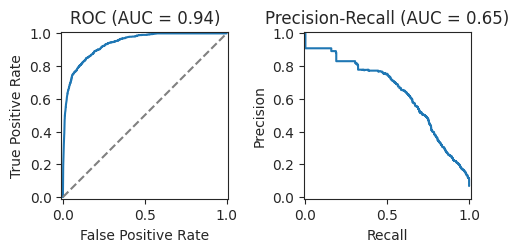

In [55]:
# Generating predicted probabilities for the positive class (Less than 50)
y_pred_proba = lgb_clss.predict_proba(X_valid)[:, 1]

# Plotting ROC and Precision-Recall curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))

# === ROC curve ===
fpr, tpr, _ = roc_curve(y_valid_encoded, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC curve plot
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LightGBM')
roc_display.plot(ax=ax1)
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line
ax1.set_title(f'ROC (AUC = {roc_auc:.2f})')

# Remove legend from ROC curve
ax1.legend([], [], frameon=False)

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_valid_encoded, y_pred_proba)
pr_auc = auc(recall, precision)

# Precision-Recall curve plot
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='LightGBM')
pr_display.plot(ax=ax2)
ax2.set_title(f'Precision-Recall (AUC = {pr_auc:.2f})')

# Remove legend from PR curve
ax2.legend([], [], frameon=False)

# Display the plots
plt.tight_layout()
plt.show()


#### Comparando os modelos

In [56]:
# Setting table information
data = {
    'Metrics': [
    'Training Accuracy',
    'Test Accuracy',
    'Validation Accuracy',
    'Training Precision',
    'Test Precision',
    'Validation Precision'
    ],
    'Logistic Regression': [
        logistic_treino_acc_1,
        logistic_teste_acc_1,
        logistic_valid_acc_1,
        logistic_treino_precision_1,
        logistic_teste_precision_1,
        logistic_valid_precision_1
    ],
    'SVC': [
        svm_treino_acc,
        svm_teste_acc,
        svm_valid_acc,
        svm_treino_precision,
        svm_teste_precision,
        svm_valid_precision
    ],
    'LGBM': [
        lgb_treino_acc,
        lgb_teste_acc,
        lgb_valid_acc,
        lgb_treino_precision,
        lgb_teste_precision,
        lgb_valid_precision
    ]
}

# Creating dataframe
metrics_df = pd.DataFrame(data)

# Using Metrics as index
metrics_df.set_index('Métricas', inplace=True)

metrics_df

KeyError: "None of ['Métricas'] are in the columns"

### Variáveis mais influentes

In [ ]:
# Accessing model coefficients
coef = logistic_classifier.coef_[0]  # For a binary classification problem

In [ ]:
importancia_variaveis = pd.DataFrame({
    'Variável': colunas_selecionadas,
    'Coeficiente': coef
})
# Sort by absolute value of coefficients to identify most influential variables
importancia_variaveis['Importância Absoluta'] = importancia_variaveis['Coeficiente'].abs()
importancia_variaveis = importancia_variaveis.sort_values(by='Importância Absoluta', ascending=False)

importancia_variaveis

In [ ]:
width_inches = 88.9 / 25.4
height_inches = width_inches * 0.7

# Creating a list of labels without '_moving_avg'
variaveis_labels = [var.replace('_moving_avg', '') for var in importancia_variaveis['Variável']]

# Creating figure
fig, ax = plt.subplots(figsize=(width_inches, height_inches))

# Creating the horizontal bar chart
bars = ax.barh(variaveis_labels, importancia_variaveis['Importância Absoluta'], color='blue')

# Axis labels
ax.set_xlabel('Absolute Coefficient', fontsize=8)
ax.set_title('Variable Importance in Logistic Regression Model', fontsize=9)

# Invert Y-axis to show most important features at the top
ax.invert_yaxis()

# Adding values to the bars
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.2f}', va='center', ha='right', color='white', fontsize=7)

plt.show()

In [ ]:
# Converting width from mm to inches
width_inches = 88.9 / 25.4
# Adjusting aspect ratio for better readability
height_inches = width_inches * 0.75

fig, ax = plt.subplots(figsize=(width_inches, height_inches))

unidades_selecionadas = [69]

# Getting the list of unique id_unidade present in the selected units
id_unidades = df_treino_mm['id_unidade'].unique()
id_unidades_selecionadas = [id for id in id_unidades if id in unidades_selecionadas]

# Iterating over each selected id_unidade to plot
for id_unidade in id_unidades_selecionadas:
    subset = df_treino_mm[df_treino_mm['id_unidade'] == id_unidade]
    ax.plot(subset['RUL'], subset['s_21_moving_avg'], label=f'Unit {id_unidade}', linewidth=1)

# Adding dashed vertical line at RUL = 50
ax.axvline(x=50, color='red', linestyle='--', linewidth=1, label='RUL = 50')

# Inverting the X-axis so it starts at the max value and ends at 0
ax.set_xlim(df_treino_mm['RUL'].max(), 0)

# Title and legend
ax.set_title('Low-pressure turbines Cool air flow vs RUL', fontsize=9)
ax.set_xlabel('RUL', fontsize=8)
ax.set_ylabel('Low-pressure turbines Cool air flow', fontsize=8)
ax.legend(title='Unit id', fontsize=7, title_fontsize=8)
ax.grid()

plt.show()

In [ ]:
# Figure size
plt.figure(figsize=(6, 4))

unidades_selecionadas = [69]

# Getting the list of unique id_unidade present in the selected units
id_unidades = df_treino_mm['id_unidade'].unique()
id_unidades_selecionadas = [id for id in id_unidades if id in unidades_selecionadas]

# Iterating over each selected id_unidade to plot
for id_unidade in id_unidades_selecionadas:
    subset = df_treino_mm[df_treino_mm['id_unidade'] == id_unidade]
    plt.plot(subset['RUL'], subset['s_12_moving_avg'], label=f'Unit {id_unidade}')

# Adding dashed vertical line at RUL = 50
plt.axvline(x=50, color='red', linestyle='--', label='RUL = 50')

# Inverting the X-axis so it starts at the max value and ends at 0
plt.xlim(df_treino_mm['RUL'].max(), 0)

# Title and legend
plt.title('Ratio of fuel flow to Ps30 vs RUL')
plt.xlabel('RUL')
plt.ylabel('Ratio of fuel flow to Ps30')
plt.legend(title='Unit id')
plt.grid()
plt.show()

In [ ]:
# Figure size
plt.figure(figsize=(6, 4))

unidades_selecionadas = [69]

# Getting the list of unique id_unidade present in the selected units
id_unidades = df_treino_mm['id_unidade'].unique()
id_unidades_selecionadas = [id for id in id_unidades if id in unidades_selecionadas]

# Iterating over each selected id_unidade to plot
for id_unidade in id_unidades_selecionadas:
    subset = df_treino_mm[df_treino_mm['id_unidade'] == id_unidade]
    plt.plot(subset['RUL'], subset['s_7_moving_avg'], label=f'Unit {id_unidade}')

# Adding dashed vertical line at RUL = 50
plt.axvline(x=50, color='red', linestyle='--', label='RUL = 50')

# Inverting the X-axis so it starts at the max value and ends at 0
plt.xlim(df_treino_mm['RUL'].max(), 0)

# Title and legend
plt.title('HPC outlet temperature vs RUL')
plt.xlabel('RUL')
plt.ylabel('HPC outlet temperature')
plt.legend(title='Unit id')
plt.grid()
plt.show()